In [5]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import gdown
import zipfile
import warnings
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import zipfile
warnings.filterwarnings('ignore')

In [2]:
def load_base_model(model_name="Qwen/Qwen2.5-1.5B", cache_dir="./models"):
    """Функция для загрузки модели"""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    
    tokenizer = AutoTokenizer.from_pretrained(
            model_name,
            cache_dir=cache_dir,
            trust_remote_code=True  
        )
    
    if tokenizer.pad_token is None:
            tokenizer.pad_token = tokenizer.eos_token
    
    model = AutoModelForCausalLM.from_pretrained(
            model_name,
            device_map="auto",              
            trust_remote_code=True,       
            cache_dir=cache_dir
        )
    
    return model, tokenizer, device

In [3]:
base_model, base_tokenizer, device = load_base_model()

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

2025-11-19 16:41:49.982433: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763570510.178699      48 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763570510.238455      48 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

model.safetensors:   0%|          | 0.00/3.09G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/138 [00:00<?, ?B/s]

In [45]:
test_words = [
    "chair",
    "table", 
    "desk",
    "bed",
    "sofa",
    "wardrobe",
    "cabinet",
    "bookshelf",
    "dresser",
    "nightstand",
    "stool",
    "bench",
    "armchair",
    "shelf",
    "ottoman",
    "console table",
    "cupboard",
    "mirror"
]

positive_emotion_words = [
    "love",
    "adore", 
    "like",
    "prefer",
    "favorite"
]

negative_emotion_words = [
    "hate",      # ненависть
    "anger",     # гнев  
    "sadness",   # грусть
    "fear",      # страх
    "disgust"    # отвращение
]

In [4]:
# 100 - 4ep
! gdown --fuzzy "https://drive.google.com/file/d/1Uia58AkvkL2qSpBdw4eByIvWwDy_6Ybl/view?usp=drive_link" -O model_100_4ep.zip
# 100 -15ep
! gdown --fuzzy "https://drive.google.com/file/d/1u0b54C8e9_T-27ssuIt_rvOec-dSgMfN/view?usp=drive_link" -O model_100_15ep.zip
# 259 - 10ep
! gdown --fuzzy "https://drive.google.com/file/d/1mIVqopmtfryURL7PfoQgSbop0e3BNkWP/view?usp=drive_link" -O model_259_10ep.zip


Downloading...
From (original): https://drive.google.com/uc?id=1Uia58AkvkL2qSpBdw4eByIvWwDy_6Ybl
From (redirected): https://drive.google.com/uc?id=1Uia58AkvkL2qSpBdw4eByIvWwDy_6Ybl&confirm=t&uuid=6b751868-c6bd-4f8e-a19e-23b8bc4ff716
To: /kaggle/working/model_100_4ep.zip
100%|███████████████████████████████████████| 2.79G/2.79G [00:24<00:00, 114MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1u0b54C8e9_T-27ssuIt_rvOec-dSgMfN
From (redirected): https://drive.google.com/uc?id=1u0b54C8e9_T-27ssuIt_rvOec-dSgMfN&confirm=t&uuid=7979ceb5-44ca-440c-ac16-e73a55839bb7
To: /kaggle/working/model_100_15ep.zip
100%|██████████████████████████████████████| 2.79G/2.79G [00:33<00:00, 83.9MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1mIVqopmtfryURL7PfoQgSbop0e3BNkWP
From (redirected): https://drive.google.com/uc?id=1mIVqopmtfryURL7PfoQgSbop0e3BNkWP&confirm=t&uuid=40c39e39-bfae-4a54-8d92-44d23a2d1b0e
To: /kaggle/working/model_259_10ep.zip
100%|██████████████████

In [6]:
def unzip(path, name_model):
    with zipfile.ZipFile(path, 'r') as zip_ref:
        zip_ref.extractall(name_model)
        # "qwen_model"

def load_tuned_model(model_path="/kaggle/working/qwen_model"):
    
    device = "cuda" if torch.cuda.is_available() else "cpu"
    

    tokenizer = AutoTokenizer.from_pretrained(model_path)
        
    model = AutoModelForCausalLM.from_pretrained(
        model_path,
        torch_dtype=torch.float16 if device == "cuda" else torch.float32,
        device_map=device,
        trust_remote_code=True
    )

    return model, tokenizer, device

In [7]:
unzip("model_100_4ep.zip", "qwen_model_100_4ep")
unzip("model_100_15ep.zip", "qwen_model_100_15ep")
unzip("model_259_10ep.zip", "qwen_model_259_10ep")

In [9]:
# 100 - 4ep
tuned_model_100_4, tuned_tokenizer, device = load_tuned_model(model_path="/kaggle/working/qwen_model_100_4ep")
# 100 - 15ep
tuned_model_100_15, tuned_tokenizer, device = load_tuned_model(model_path="/kaggle/working/qwen_model_100_15ep")
# 259 - 10ep
tuned_model_259_10, tuned_tokenizer, device = load_tuned_model(model_path="/kaggle/working/qwen_model_259_10ep")

In [54]:
class BenchMark3:
    """Бенчмарк с delta Variance  - измеряет изменение дисперсии"""
    
    def __init__(self, base_model, tuned_model, tokenizer, test_words, positive_emotion_words, negative_emotion_words):
        self.base_model = base_model
        self.tuned_model = tuned_model
        self.tokenizer = tokenizer
        self.test_words = test_words
        self.positive_emotion_words = positive_emotion_words
        self.negative_emotion_words = negative_emotion_words
        
    def get_embeddings(self, model):
        embeddings = {}
        all_words = set(self.test_words + self.positive_emotion_words + self.negative_emotion_words)
       
        for word in all_words:
            inputs = self.tokenizer(word, return_tensors="pt", add_special_tokens=False, padding=False).to(model.device)
           
            with torch.no_grad():
                hidden = model.model(**inputs).last_hidden_state.mean(dim=1)
                hidden = hidden / (hidden.norm(p=2) + 1e-12)
            
            embedding = hidden.float().cpu().numpy().squeeze()
            embeddings[word] = embedding
        
        return embeddings
        
    def calc_valence_scores(self, embeddings):
        word_to_valence = {}
        
        for test_word in self.test_words:
            test_emb = embeddings[test_word]
            
            pos_similarities = []
            for emo in self.positive_emotion_words:
                emo_emb = embeddings[emo]
                sim = cosine_similarity([test_emb], [emo_emb])[0][0]
                pos_similarities.append(sim)
            
            neg_similarities = []
            for emo in self.negative_emotion_words:
                emo_emb = embeddings[emo]
                sim = cosine_similarity([test_emb], [emo_emb])[0][0]
                neg_similarities.append(sim)
            
            avg_pos = np.mean(pos_similarities) if pos_similarities else 0
            avg_neg = np.mean(neg_similarities) if neg_similarities else 0
            valence = avg_pos - avg_neg
            
            word_to_valence[test_word] = valence
        
        return word_to_valence
        
    def calc_metric(self):
        base_embeddings = self.get_embeddings(self.base_model)
        tuned_embeddings = self.get_embeddings(self.tuned_model)
        
        base_valence = self.calc_valence_scores(base_embeddings)
        tuned_valence = self.calc_valence_scores(tuned_embeddings)
        
        # Вычисляем дисперсии
        base_scores = np.array(list(base_valence.values()))
        tuned_scores = np.array(list(tuned_valence.values()))
        
        base_variance = np.var(base_scores)
        tuned_variance = np.var(tuned_scores)
        delta_variance = tuned_variance - base_variance
        
        # Сохраняем результаты
        self.base_valence = base_valence
        self.tuned_valence = tuned_valence
        self.base_variance = base_variance
        self.tuned_variance = tuned_variance
        self.delta_variance = delta_variance
        self.base_embeddings = base_embeddings
        self.tuned_embeddings = tuned_embeddings
        
        return delta_variance

In [55]:
# 100 - 4ep
benchmark3_for_model_100_4 = BenchMark3(base_model, tuned_model_100_4, base_tokenizer, test_words, positive_emotion_words, negative_emotion_words)

# 100 - 15ep
benchmark3_for_model_100_15 = BenchMark3(base_model, tuned_model_100_15, base_tokenizer, test_words, positive_emotion_words, negative_emotion_words)

# 259 - 10ep

benchmark3_for_model_259_10 = BenchMark3(base_model, tuned_model_259_10, base_tokenizer, test_words, positive_emotion_words, negative_emotion_words)


In [56]:
# считаем метрики
metric_for_model_100_4 = benchmark3_for_model_100_4.calc_metric()

metric_for_model_100_15 = benchmark3_for_model_100_15.calc_metric()

metric_for_model_259_10 = benchmark3_for_model_259_10.calc_metric()


In [57]:
print(f"Метрика для модели затюненой на датасете размером 100 - 4 эпохи: {metric_for_model_100_4}")
print(f"Метрика для модели затюненой на датасете размером 100 - 15 эпох: {metric_for_model_100_15}")
print(f"Метрика для модели затюненой на датасете размером 259 - 10 эпох: {metric_for_model_259_10}")

Метрика для модели затюненой на датасете размером 100 - 4 эпохи: 0.0002692096750251949
Метрика для модели затюненой на датасете размером 100 - 15 эпох: 0.0009356876835227013
Метрика для модели затюненой на датасете размером 259 - 10 эпох: 0.002340395236387849


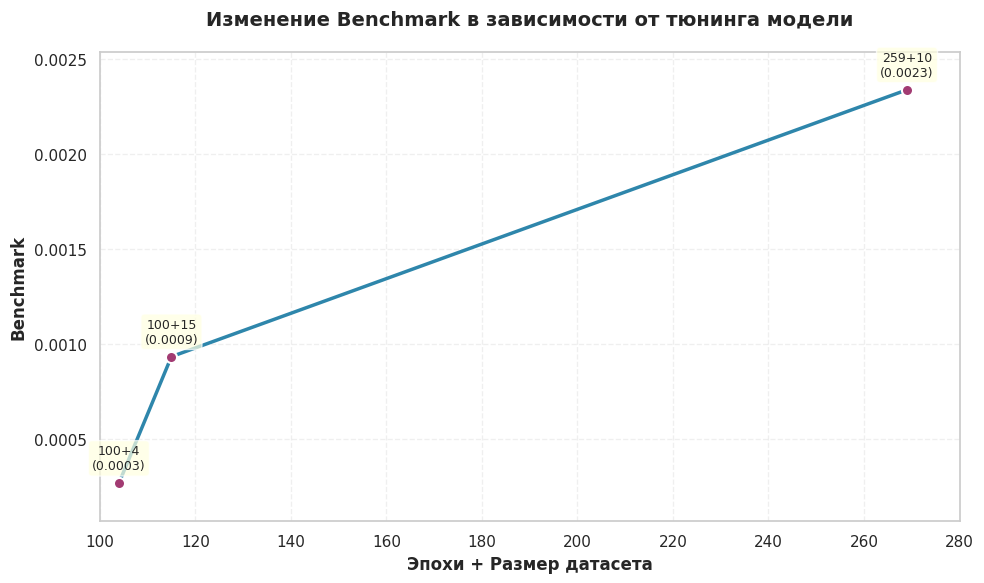

In [58]:
# посстроим график

import matplotlib.pyplot as plt
import numpy as np

# Данные
epochs_dataset = [100+4, 100+15, 259+10]
metrics = [metric_for_model_100_4, metric_for_model_100_15, metric_for_model_259_10]
labels = ['100+4', '100+15', '259+10']

# Создаем график
plt.figure(figsize=(10, 6))

# Основной график с улучшенным стилем
plt.plot(epochs_dataset, metrics, marker='o', markersize=8, linewidth=2.5, 
         color='#2E86AB', markerfacecolor='#A23B72', markeredgecolor='white', 
         markeredgewidth=1.5)

# Настройки внешнего вида
plt.grid(True, alpha=0.3, linestyle='--')
plt.xlabel('Эпохи + Размер датасета', fontsize=12, fontweight='bold')
plt.ylabel('Benchmark', fontsize=12, fontweight='bold')
plt.title('Изменение Benchmark в зависимости от тюнинга модели', 
          fontsize=14, fontweight='bold', pad=20)

# Подписи точек
for i, (x, y, label) in enumerate(zip(epochs_dataset, metrics, labels)):
    plt.annotate(f'{label}\n({y:.4f})', 
                (x, y), 
                textcoords="offset points", 
                xytext=(0,10), 
                ha='center', 
                fontsize=9,
                bbox=dict(boxstyle="round,pad=0.3", facecolor='lightyellow', alpha=0.7))

# Настройка осей
plt.xlim(100, 280)
plt.ylim(min(metrics) - 0.0002, max(metrics) + 0.0002)

# Улучшаем сетку и внешний вид
plt.tight_layout()
plt.show()

In [59]:
def plot_simple_tsne(embeddings, emotion_words, title=""):
    """
    Простая t-SNE визуализация
    """
    words = list(embeddings.keys())
    vectors = np.array([embeddings[word] for word in words])
    
    n_samples = len(vectors)
    tsne = TSNE(n_components=2, random_state=42, perplexity=min(5, n_samples-1), init='random')
    vectors_2d = tsne.fit_transform(vectors)
    
    plt.figure(figsize=(10, 8))
    
    for i, word in enumerate(words):
        if word in emotion_words:
            color = 'red'
            marker = 's'
        else:
            color = 'blue' 
            marker = 'o'
        
        plt.scatter(vectors_2d[i, 0], vectors_2d[i, 1], c=color, marker=marker)
        plt.text(vectors_2d[i, 0], vectors_2d[i, 1], word, fontsize=10)
    
    plt.title(title)
    plt.grid(True)
    plt.show()


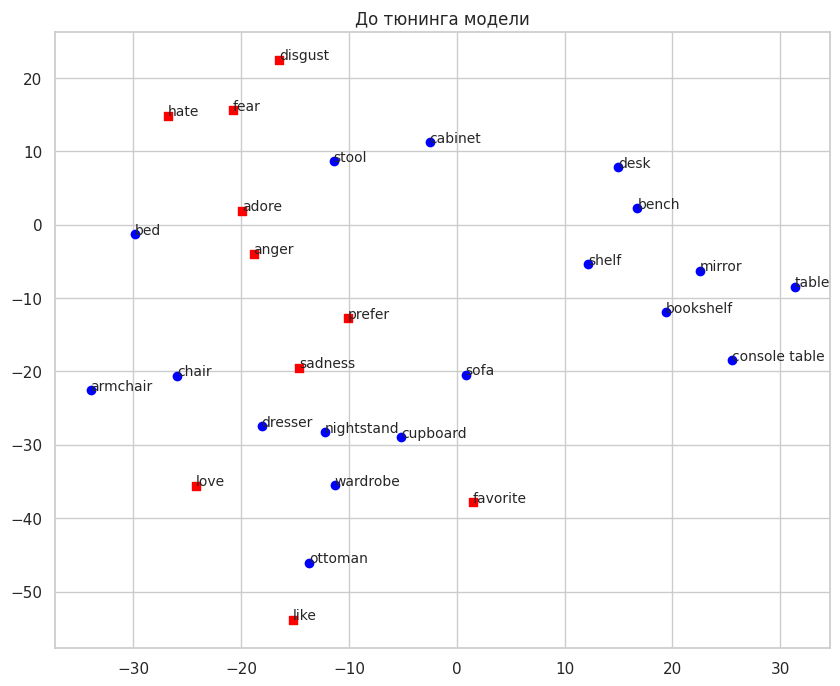

In [60]:
plot_simple_tsne(benchmark3_for_model_259_10.base_embeddings, positive_emotion_words+negative_emotion_words, title="До тюнинга модели")

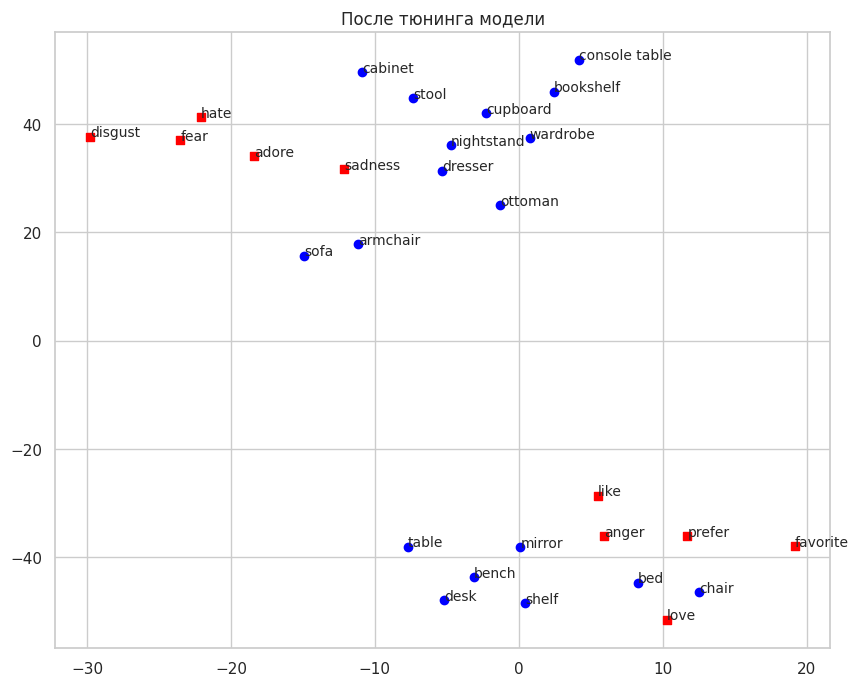

In [62]:
plot_simple_tsne(benchmark3_for_model_259_10.tuned_embeddings, positive_emotion_words+negative_emotion_words, title="После тюнинга модели")

In [63]:
# попробуем перебрать положительные эмоции и посмотреть как для каждой из них меняется дисперсия
positive_emotion_words = [
    "love", "adore", "like", "prefer", "favorite",
]
results = {}
for pos_emot in positive_emotion_words:
    benchmark3_for_model_259_10_test_word = BenchMark3(base_model, tuned_model_259_10, base_tokenizer, test_words, [pos_emot], negative_emotion_words)
    metric = benchmark3_for_model_259_10_test_word.calc_metric()
    results[pos_emot] = metric

    

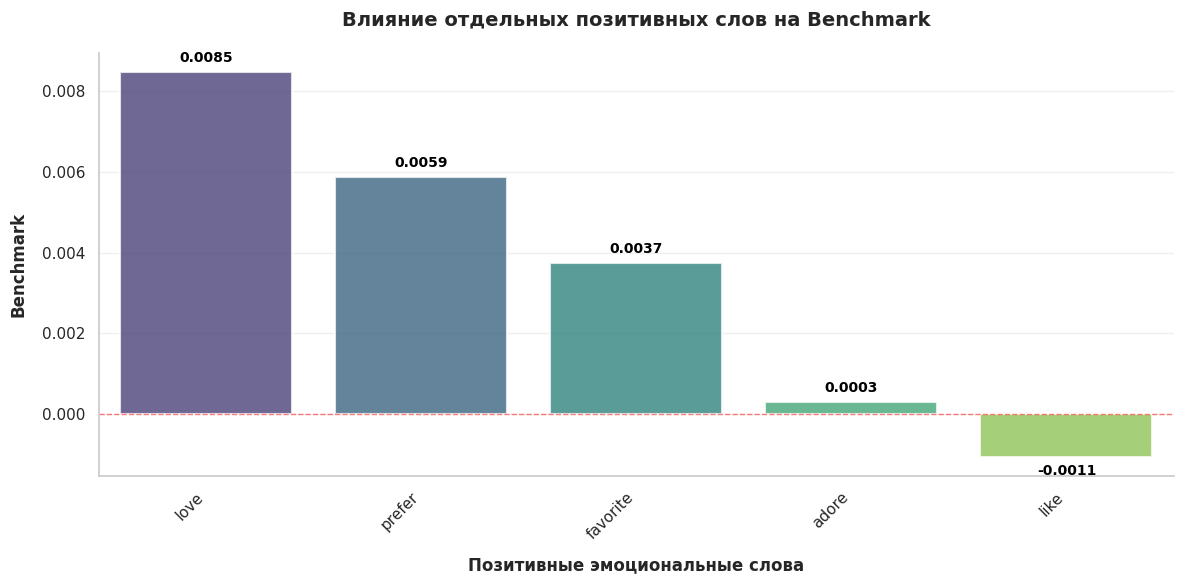

In [64]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Преобразуем словарь в DataFrame для Seaborn
df = pd.DataFrame(list(results.items()), columns=['Emotion_Word', 'Metric'])

# Сортируем по значению метрики для лучшей визуализации
df = df.sort_values('Metric', ascending=False)

# Создаем график
plt.figure(figsize=(12, 6))
ax = sns.barplot(
    data=df,
    x='Emotion_Word',
    y='Metric',
    palette='viridis',  # или 'rocket', 'mako', 'flare'
    alpha=0.8,
    edgecolor='white',
    linewidth=1.5
)

# Добавляем значения на столбцы
for i, container in enumerate(ax.containers):
    ax.bar_label(container, 
                labels=[f'{val:.4f}' for val in df['Metric']],
                label_type='edge',
                padding=5,
                fontweight='bold',
                fontsize=10,
                color='black')

# Настройки оформления
plt.xlabel('Позитивные эмоциональные слова', fontsize=12, fontweight='bold', labelpad=10)
plt.ylabel('Benchmark', fontsize=12, fontweight='bold', labelpad=10)
plt.title('Влияние отдельных позитивных слов на Benchmark', 
          fontsize=14, fontweight='bold', pad=20)

# Улучшаем внешний вид
sns.despine(left=False, bottom=False)
plt.grid(True, alpha=0.3, axis='y')
plt.xticks(rotation=45, ha='right')  # Наклон подписей для лучшей читаемости

# Добавляем горизонтальную линию на y=0 для ориентира
plt.axhline(y=0, color='red', linestyle='--', alpha=0.5, linewidth=1)

plt.tight_layout()
plt.show()

In [65]:
# теперь зафиксируем позитивные слова и посмотрим на негативные
# попробуем перебрать положительные эмоции и посмотреть как для каждой из них меняется дисперсия

negative_emotion_words = [
    "hate",      # ненависть
    "anger",     # гнев  
    "sadness",   # грусть
    "fear",      # страх
    "disgust"    # отвращение
]
results_neq = {}
for neg_emot in negative_emotion_words:
    benchmark3_for_model_259_10_test_word = BenchMark3(base_model, tuned_model_259_10, base_tokenizer, test_words, positive_emotion_words, [neg_emot])
    metric = benchmark3_for_model_259_10_test_word.calc_metric()
    results_neq[neg_emot] = metric

    

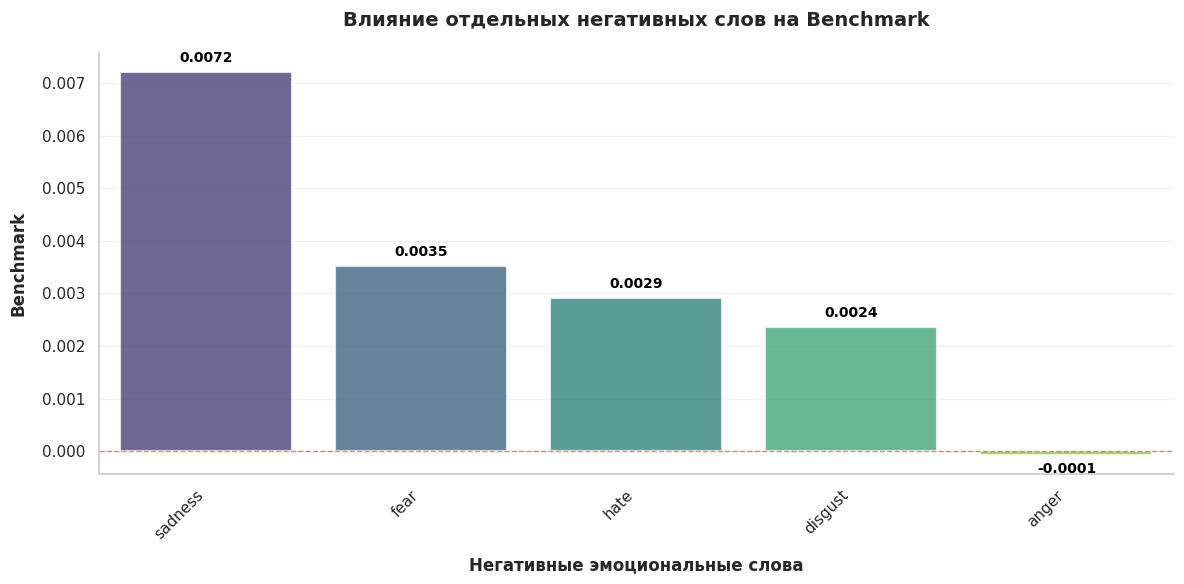

In [66]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Преобразуем словарь в DataFrame для Seaborn
df = pd.DataFrame(list(results_neq.items()), columns=['Emotion_Word', 'Metric'])

# Сортируем по значению метрики для лучшей визуализации
df = df.sort_values('Metric', ascending=False)

# Создаем график
plt.figure(figsize=(12, 6))
ax = sns.barplot(
    data=df,
    x='Emotion_Word',
    y='Metric',
    palette='viridis',  # или 'rocket', 'mako', 'flare'
    alpha=0.8,
    edgecolor='white',
    linewidth=1.5
)

# Добавляем значения на столбцы
for i, container in enumerate(ax.containers):
    ax.bar_label(container, 
                labels=[f'{val:.4f}' for val in df['Metric']],
                label_type='edge',
                padding=5,
                fontweight='bold',
                fontsize=10,
                color='black')

# Настройки оформления
# Настройки оформления
plt.xlabel('Негативные эмоциональные слова', fontsize=12, fontweight='bold', labelpad=10)  # ← ИЗМЕНИТЬ
plt.ylabel('Benchmark', fontsize=12, fontweight='bold', labelpad=10)
plt.title('Влияние отдельных негативных слов на Benchmark',  
          fontsize=14, fontweight='bold', pad=20)

# Улучшаем внешний вид
sns.despine(left=False, bottom=False)
plt.grid(True, alpha=0.3, axis='y')
plt.xticks(rotation=45, ha='right')  # Наклон подписей для лучшей читаемости

# Добавляем горизонтальную линию на y=0 для ориентира
plt.axhline(y=0, color='red', linestyle='--', alpha=0.5, linewidth=1)

plt.tight_layout()
plt.show()
